## Thompson sampling and the Binary Bernoulli Bandit Problem

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Multiarm-Bandit-TS`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Multiarm-Bandit-TS/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Multiarm-Bandit-TS/Manifest.toml`


In [2]:
# load reqd packages -
using Distributions
using Plots
using Colors
using StatsPlots
using PrettyTables
using DataFrames

# setup paths -
const _ROOT = pwd();
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

In [3]:
include("CHEME-5660-Example-CodeLib.jl");

In [4]:
# initialize the world -
world_d_dict = Dict{Int64, Bernoulli}();
K = 3;
θ_array = [0.90, 0.60, 0.80]; # values taken from Russo et al Fig. 3.1
number_of_steps = 5000;
    
# hard code the parameters for the Bernoulli distributions, these are the 
# ground truth, but the agent doesn't know them (and they are directly visible)
for k ∈ 1:K
    world_d_dict[k] = Bernoulli(θ_array[k]);
end

In [5]:
# lets build a world function -
function world(action::Int64, dict::Dict{Int64, Bernoulli})::Int64
    
    # grab the distrubution from the dict -
    d = dict[action];
    
    # roll -
    value = rand(d);
    if (value == true)
        return 1;    
    end
    
    # default -
    return 0;
end

world (generic function with 2 methods)

In [6]:
# build Thompson sample object -
model = ThompsonSamplingModel()
model.K = K;
model.α = ones(K); # initialize to uniform values
model.β = ones(K); # initialize to uniform values

# build the world function 
world_function(a) = world(a, world_d_dict);

# TS -
time_sample_results_dict_Ts = sample(model; 𝒯 = number_of_steps, world=world_function);

In [7]:
# Build an epsilon sample object -
epsilon_model = EpsilonSamplingModel();
epsilon_model.K = K;
epsilon_model.α = ones(K); # initialize to uniform values
epsilon_model.β = ones(K); # initialize to uniform values
epsilon_model.ϵ = 0.20; # some fraction of the iterations, do a random step

# EPS-TS 
time_sample_results_dict_eps = sample(epsilon_model; 𝒯 = number_of_steps, world=world_function);

In [8]:
time_sample_results_dict_eps

Dict{Int64, Matrix{Float64}} with 5000 entries:
  4986 => [3846.0 423.0; 206.0 126.0; 316.0 74.0]
  4700 => [3617.0 398.0; 196.0 122.0; 299.0 73.0]
  4576 => [3514.0 387.0; 191.0 121.0; 295.0 73.0]
  2288 => [1718.0 187.0; 95.0 75.0; 176.0 42.0]
  1703 => [1251.0 145.0; 75.0 55.0; 149.0 33.0]
  1956 => [1449.0 163.0; 85.0 65.0; 162.0 37.0]
  2350 => [1762.0 193.0; 100.0 76.0; 181.0 43.0]
  3406 => [2592.0 287.0; 153.0 93.0; 231.0 55.0]
  2841 => [2147.0 242.0; 124.0 82.0; 205.0 46.0]
  2876 => [2172.0 246.0; 125.0 83.0; 207.0 48.0]
  687  => [439.0 64.0; 46.0 24.0; 97.0 22.0]
  185  => [109.0 14.0; 15.0 9.0; 35.0 8.0]
  1090 => [760.0 98.0; 59.0 36.0; 113.0 29.0]
  2015 => [1494.0 168.0; 87.0 67.0; 166.0 38.0]
  3293 => [2504.0 275.0; 145.0 91.0; 230.0 53.0]
  1704 => [1252.0 145.0; 75.0 55.0; 149.0 33.0]
  3220 => [2450.0 269.0; 140.0 89.0; 225.0 52.0]
  4888 => [3766.0 414.0; 201.0 125.0; 313.0 74.0]
  422  => [253.0 43.0; 31.0 14.0; 69.0 17.0]
  1266 => [906.0 111.0; 63.0 42.0; 120.

In [9]:
# build a pretty table -
# pick a time step -
T_index = 5000

# build the array of beta distributions -
beta_array_Ts = build_beta_array(time_sample_results_dict_Ts[T_index]);
beta_array_eps = build_beta_array(time_sample_results_dict_eps[T_index]);

# initialize -
action_probability_array = Array{Any,2}(undef, K, 4);
for i ∈ 1:K
    
    action_probability_array[i,1] = i;
    action_probability_array[i,2] = θ_array[i];
    
    # get the d -
    d_Ts = beta_array_Ts[i];
    d_eps = beta_array_eps[i];
    
    # grab the parameters from distributions -
    # Thompson sampling -
    αᵢ,βᵢ = params(d_Ts);
    action_probability_array[i,3] = αᵢ/(αᵢ + βᵢ);
    
    # eps-TS -
    αᵢ,βᵢ = params(d_eps);
    action_probability_array[i,4] = αᵢ/(αᵢ + βᵢ);
end

# header -
action_table_header = (["Action aᵢ", "θᵢ", "θ̂ᵢ Ts", "θ̂ᵢ eps-Ts"]);

# display table -
pretty_table(action_probability_array; header = action_table_header)

┌───────────┬─────┬──────────┬───────────┐
│ Action aᵢ │  θᵢ │    θ̂ᵢ Ts │ θ̂ᵢ eps-Ts │
├───────────┼─────┼──────────┼───────────┤
│         1 │ 0.9 │ 0.901227 │  0.901191 │
│         2 │ 0.6 │ 0.571429 │  0.620482 │
│         3 │ 0.8 │     0.55 │  0.811224 │
└───────────┴─────┴──────────┴───────────┘


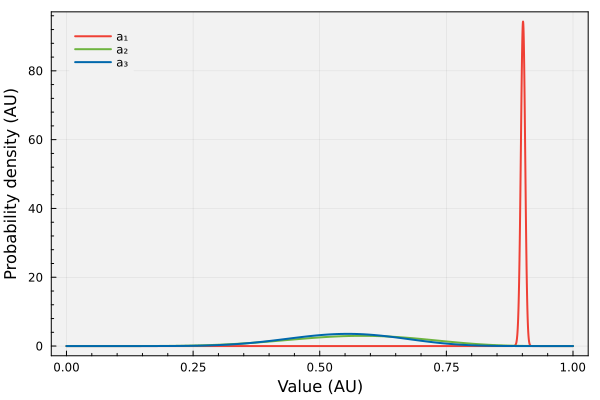

In [10]:
 # get the distributions for this time point -
plot(beta_array_Ts[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_Ts[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_Ts[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

# uncomment me to save -
#filename = "Fig-BBBP-Ts-T$(T_index).pdf"
#savefig(joinpath(_PATH_TO_FIGS, filename));

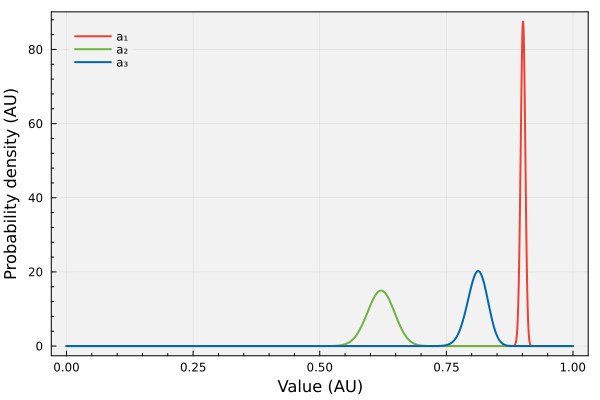

In [11]:
 # get the distributions for this time point -
plot(beta_array_eps[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_eps[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_eps[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

# uncomment me to save -
#filename = "Fig-BBBP-eps-20-T$(T_index).pdf"
#savefig(joinpath(_PATH_TO_FIGS, filename));

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.